# Assignment — Three Body Problem


In [ ]:
# Imports & config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor


SEED = 42
TRAIN_PATH = '../data/X_train.csv'
TEST_PATH  = '../data/X_test.csv'

SPLIT_TRAIN = 0.70
SPLIT_VAL   = 0.15
SPLIT_TEST  = 0.15
assert abs(SPLIT_TRAIN + SPLIT_VAL + SPLIT_TEST - 1.0) < 1e-9

# ============================================
# 🧩 Task 1.2 — Data Preparation & Validation
# ============================================

In [34]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print('Train shape:', train.shape, '| Test shape:', test.shape)
display(train.head())

unique_t = np.sort(train['t'].unique())
STEPS_PER_TRAJ = len(unique_t)

train = train.reset_index(drop=True)
train['traj_idx'] = train.index // STEPS_PER_TRAJ
train['step_idx'] = train.index % STEPS_PER_TRAJ

# Conta por trajetoria
per_traj_counts = train.groupby('traj_idx').size()

expected_lines = 258
n_traj = per_traj_counts.shape[0]
n_exact_258 = int((per_traj_counts == expected_lines).sum())

init_rows = (train[train['step_idx']==0]
             [['traj_idx','x_1','y_1','x_2','y_2','x_3','y_3']]
             .rename(columns={'x_1':'x0_1','y_1':'y0_1','x_2':'x0_2','y_2':'y0_2','x_3':'x0_3','y_3':'y0_3'}))
train = train.merge(init_rows, on='traj_idx', how='left')

# Verifica a velocidade no t=0
vel_zero_sum = (train[train['step_idx']==0][['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3']].abs().sum().sum())

# Detecção de Colisão
target_cols  = ['x_1','y_1','x_2','y_2','x_3','y_3']

def first_zero_step(g):
    mask = (g[target_cols].abs().sum(axis=1) == 0.0)
    idx = np.where(mask.values)[0]
    return int(idx[0]) if len(idx)>0 else np.nan

first_zero = (train
              .groupby('traj_idx', group_keys=False,) 
              .apply(first_zero_step))
n_collide  = int(first_zero.notna().sum())

violations = 0
for tidx, fz in first_zero.dropna().items():
    fz = int(fz)
    g = train[train['traj_idx']==tidx].sort_values('step_idx')
    tail = g[g['step_idx']>=fz][target_cols].abs().sum(axis=1)
    if not np.all(tail.values == 0.0):
        violations += 1

valid_mask  = (train[target_cols].abs().sum(axis=1) > 0.0)
train_valid = train[valid_mask].copy()
feature_cols = ['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']

Train shape: (1285000, 14) | Test shape: (1041621, 8)


,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


C:\Users\DESKTOP\AppData\Local\Temp\ipykernel_29560\924354671.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(first_zero_step))


### Visualizações (inline)

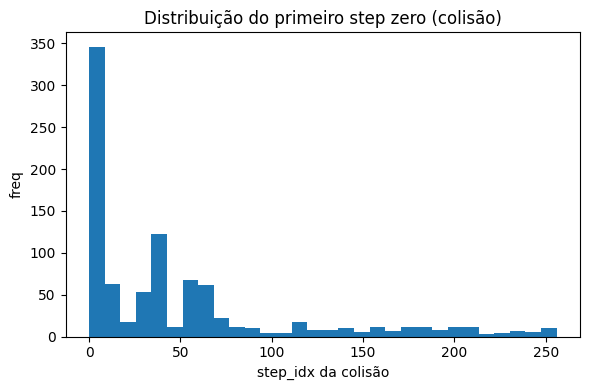

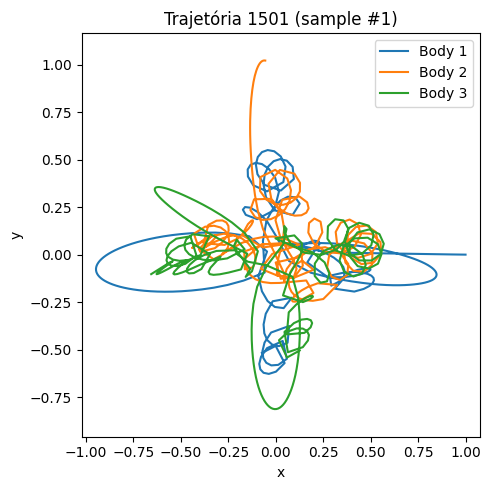

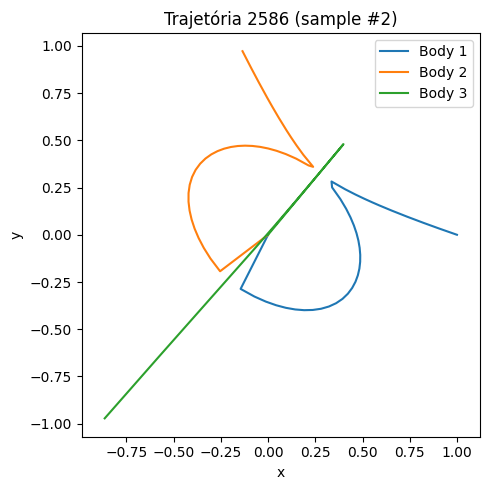

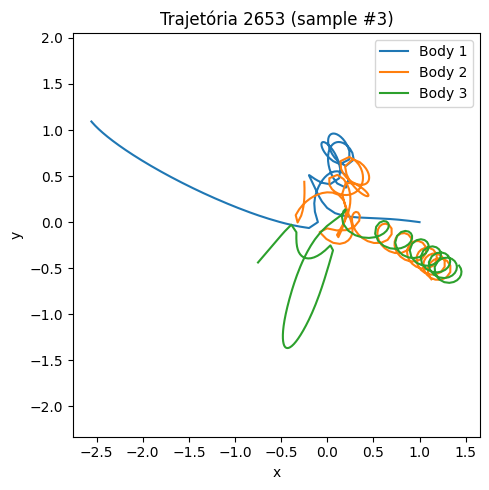

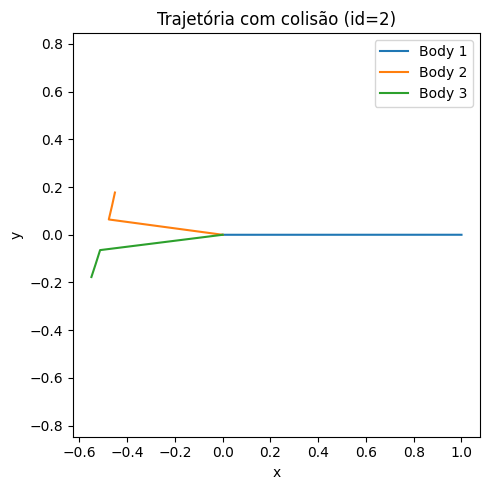

In [ ]:
# Histograma do primeiro step zero (colisão)
if n_collide > 0:
    plt.figure(figsize=(6,4))
    first_zero.dropna().astype(int).plot(kind='hist', bins=30)
    plt.title('Distribuição do primeiro step zero (colisão)')
    plt.xlabel('step_idx da colisão')
    plt.ylabel('freq')
    plt.tight_layout()
    plt.show()
else:
    print('Sem colisões detetadas para o histograma.')

# 3 trajetórias aleatórias
np.random.seed(SEED)
all_traj = train['traj_idx'].unique()
sample_trajs = np.random.choice(all_traj, size=min(3, len(all_traj)), replace=False)

for i, ti in enumerate(sample_trajs, start=1):
    g = train[train['traj_idx']==ti].sort_values('step_idx')
    plt.figure(figsize=(5,5))
    plt.plot(g['x_1'], g['y_1'], label='Body 1')
    plt.plot(g['x_2'], g['y_2'], label='Body 2')
    plt.plot(g['x_3'], g['y_3'], label='Body 3')
    plt.title(f'Trajetória {ti} (sample #{i})')
    plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal'); plt.legend()
    plt.tight_layout()
    plt.show()

# Uma trajetória com colisão
if n_collide > 0:
    collide_tid = first_zero.dropna().index[0]
    g = train[train['traj_idx']==collide_tid].sort_values('step_idx')
    plt.figure(figsize=(5,5))
    plt.plot(g['x_1'], g['y_1'], label='Body 1')
    plt.plot(g['x_2'], g['y_2'], label='Body 2')
    plt.plot(g['x_3'], g['y_3'], label='Body 3')
    plt.title(f'Trajetória com colisão (id={collide_tid})')
    plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal'); plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================
# 🧩 Task 1.2 — Baseline: StandardScaler + LinearRegression
# ============================================

In [5]:
# Split 70/15/15 por trajetória (sem vazamento)
traj_ids = np.array(sorted(train_valid['traj_idx'].unique()))
n_traj = len(traj_ids)
traj_train, traj_temp = train_test_split(traj_ids, test_size=(SPLIT_VAL + SPLIT_TEST), random_state=SEED, shuffle=True)
traj_val, traj_test   = train_test_split(traj_temp, test_size=(SPLIT_TEST/(SPLIT_VAL+SPLIT_TEST)), random_state=SEED, shuffle=True)

def subset_by_trajs(df, trajs): return df[df['traj_idx'].isin(trajs)]

df_tr = subset_by_trajs(train_valid, traj_train)
df_va = subset_by_trajs(train_valid, traj_val)
df_te = subset_by_trajs(train_valid, traj_test)

print('Traj counts -> train/val/test:', len(traj_train), len(traj_val), len(traj_test))
print('Proporções (traj):', 
      round(len(traj_train)/n_traj,3), 
      round(len(traj_val)/n_traj,3), 
      round(len(traj_test)/n_traj,3))

# Prova de não-sobreposição das condições iniciais
def initial_tuple(df):
    starts = df[df['step_idx']==0][['x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
    starts['key'] = list(map(tuple, starts.values))
    return set(starts['key'].tolist())

init_tr = initial_tuple(df_tr); init_va = initial_tuple(df_va); init_te = initial_tuple(df_te)
overlap_any = (init_tr & init_va) | (init_tr & init_te) | (init_va & init_te)
print('Sobreposição de condições iniciais entre conjuntos? ->', 'SIM' if len(overlap_any)>0 else 'NÃO')

Traj counts -> train/val/test: 3498 750 750
Proporções (traj): 0.7 0.15 0.15
Sobreposição de condições iniciais entre conjuntos? -> NÃO


In [6]:
# Matrices
feature_cols = ['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']
target_cols  = ['x_1','y_1','x_2','y_2','x_3','y_3']

X_tr = df_tr[feature_cols].values
y_tr = df_tr[target_cols].values
X_va = df_va[feature_cols].values
y_va = df_va[target_cols].values
X_te_local = df_te[feature_cols].values
y_te_local = df_te[target_cols].values

# Baseline pipeline
baseline = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
baseline.fit(X_tr, y_tr)

y_pred_tr = baseline.predict(X_tr)
y_pred_va = baseline.predict(X_va)
y_pred_te = baseline.predict(X_te_local)

rmse_tr = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
rmse_va = np.sqrt(mean_squared_error(y_va, y_pred_va))
rmse_te = np.sqrt(mean_squared_error(y_te_local, y_pred_te))

print(f'RMSE treino:      {rmse_tr:.6f}')
print(f'RMSE validação:   {rmse_va:.6f}')
print(f'RMSE teste local: {rmse_te:.6f}')

RMSE treino:      1.390101
RMSE validação:   1.413693
RMSE teste local: 1.440929


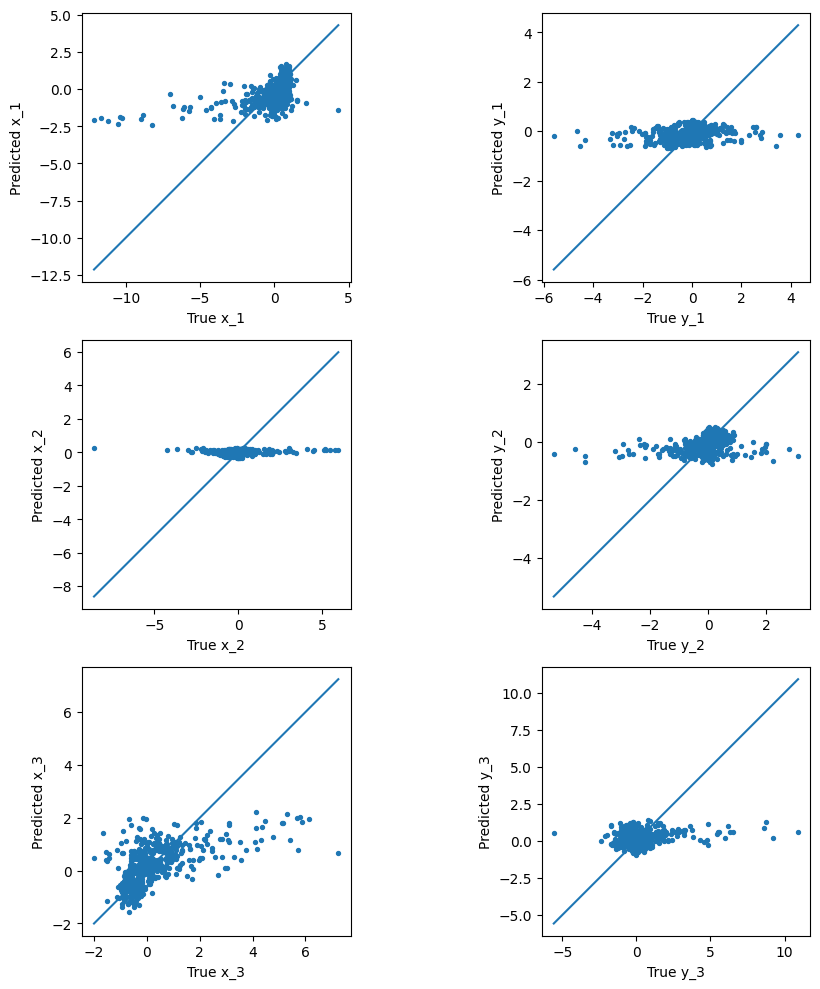

In [7]:
# y–ŷ plot (validação) inline
def plot_y_yhat_inline(y_test, y_pred):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    idx = np.random.choice(len(y_test), min(MAX, len(y_test)), replace=False)
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i]); x1 = np.max(y_test[idx,i])
        ax = plt.subplot(3,2,i+1)
        ax.scatter(y_test[idx,i], y_pred[idx,i], s=8)
        ax.plot([x0,x1],[x0,x1])
        ax.set_xlabel('True '+labels[i]); ax.set_ylabel('Predicted '+labels[i])
        ax.set_aspect('equal','box')
    plt.tight_layout()
    plt.show()

plot_y_yhat_inline(y_va, y_pred_va)

### Submissão Kaggle — `baseline-model.csv` (treino em train+val)

In [12]:
X_tr_full = pd.concat([df_tr[feature_cols], df_va[feature_cols]], axis=0).values
y_tr_full = pd.concat([df_tr[target_cols],  df_va[target_cols]],  axis=0).values

baseline_full = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())]).fit(X_tr_full, y_tr_full)

X_submit = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].values
y_submit = baseline_full.predict(X_submit)

submission = pd.DataFrame({
    'Id': test['Id'],
    'x_1': y_submit[:,0],
    'y_1': y_submit[:,1],
    'x_2': y_submit[:,2],
    'y_2': y_submit[:,3],
    'x_3': y_submit[:,4],
    'y_3': y_submit[:,5],
})
submission.to_csv('../outputs/baseline-model.csv', index=False)
print('Wrote baseline-model.csv')

Wrote baseline-model.csv


# ============================================
# 🧩 Task 2.1 — Baseline Linear/Ridge (validação)
# ============================================

In [ ]:
def validate_poly_regression(X_train, y_train, X_val, y_val, 
                             regressor=None, 
                             degrees=range(1,15), 
                             subset_frac=None, 
                             random_state=None):
    """Valida regressão polinomial para vários graus e retorna o melhor pipeline e RMSE."
    """
    if regressor is None or regressor == 'linear':
        reg = LinearRegression()
    elif regressor == 'ridge':
        reg = RidgeCV(alphas=np.logspace(-4, 4, 13))
    else:
        reg = regressor
    
    if subset_frac is not None and 0 < subset_frac < 1.0:
        n_sub = max(1000, int(len(X_train) * subset_frac))
        rng = np.random.RandomState(random_state)
        idx = rng.choice(len(X_train), size=n_sub, replace=False)
        X_tr = X_train[idx]
        y_tr = y_train[idx]
    else:
        X_tr, y_tr = X_train, y_train
    
    best_rmse = np.inf
    best_model = None
    rmse_by_d = []
    feats_by_d = []
    results = {}
    
    for d in degrees:
        poly = PolynomialFeatures(degree=d, include_bias=False)
        pipe = Pipeline([('poly', poly), ('scaler', StandardScaler()), ('reg', reg)])
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        n_out_feats = pipe.named_steps['poly'].n_output_features_
        results[d] = {'rmse': rmse, 'n_features': n_out_feats}
        rmse_by_d.append(rmse)
        feats_by_d.append(n_out_feats)
        print(f"grau={d:2d} | n_features={n_out_feats:5d} | RMSE_val={rmse:.6f}")
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = pipe
    
    # Plot inline: RMSE vs grau e number of features
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.plot(list(degrees), rmse_by_d, marker='o')
    ax1.set_xlabel('Grau polinomial')
    ax1.set_ylabel('RMSE (validação)')
    ax2 = ax1.twinx()
    ax2.plot(list(degrees), feats_by_d, marker='x')
    ax2.set_ylabel('Nº de features')
    plt.title('RMSE vs Grau (linha) e Nº de Features (cruzes)')
    plt.tight_layout()
    plt.show()
    
    return best_model, best_rmse, results

### Run: LinearRegression

grau= 1 | n_features=    7 | RMSE_val=1.413474
grau= 2 | n_features=   35 | RMSE_val=1.382914
grau= 3 | n_features=  119 | RMSE_val=1.346620
grau= 4 | n_features=  329 | RMSE_val=1.305467
grau= 5 | n_features=  791 | RMSE_val=1.265857
grau= 6 | n_features= 1715 | RMSE_val=1.239333
grau= 7 | n_features= 3431 | RMSE_val=1.219848


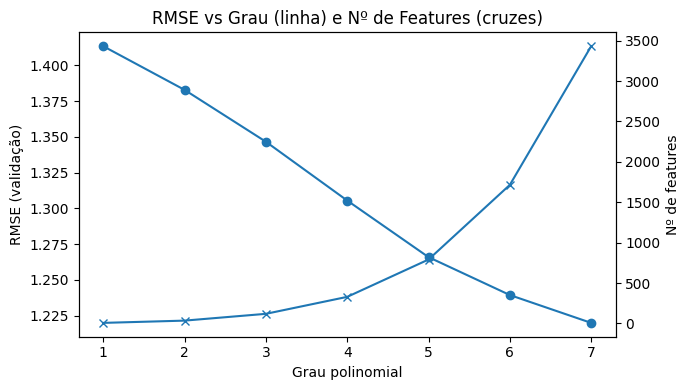


Melhor (Linear): RMSE_val = 1.2198482583538766


In [9]:
best_lin_model, best_lin_rmse, lin_results = validate_poly_regression(
    X_tr, y_tr, X_va, y_va,
    regressor='linear',
    degrees=range(1,8),
    subset_frac=0.05,
    random_state=SEED
)
print('\nMelhor (Linear): RMSE_val =', best_lin_rmse)

### Run: RidgeCV

grau= 1 | n_features=    7 | RMSE_val=1.413477
grau= 2 | n_features=   35 | RMSE_val=1.382905
grau= 3 | n_features=  119 | RMSE_val=1.346592
grau= 4 | n_features=  329 | RMSE_val=1.305467
grau= 5 | n_features=  791 | RMSE_val=1.265906
grau= 6 | n_features= 1715 | RMSE_val=1.239258
grau= 7 | n_features= 3431 | RMSE_val=1.219817


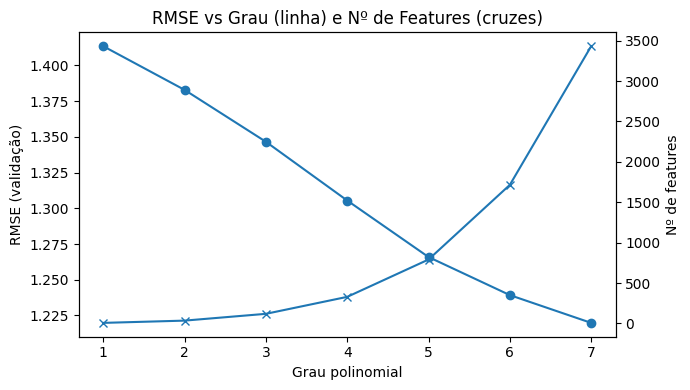


Melhor (RidgeCV): RMSE_val = 1.2198171494934948


In [10]:
best_ridge_model, best_ridge_rmse, ridge_results = validate_poly_regression(
    X_tr, y_tr, X_va, y_va,
    regressor='ridge',
    degrees=range(1,8),
    subset_frac=0.05,
    random_state=SEED
)
print('\nMelhor (RidgeCV): RMSE_val =', best_ridge_rmse)

### 10 execuções (distribuição do grau ótimo)

In [ ]:
def run_many(n_runs=10, regressor='ridge', subset_frac=0.10, degrees=range(1,15)):
    best_degrees = []
    best_rmses   = []
    for i in range(n_runs):
        seed_i = SEED + i
        model, rmse, res = validate_poly_regression(
            X_tr, y_tr, X_va, y_va,
            regressor=regressor,
            degrees=degrees,
            subset_frac=subset_frac,
            random_state=seed_i
        )
        d_best = min(res.keys(), key=lambda d: res[d]['rmse'])
        best_degrees.append(d_best)
        best_rmses.append(rmse)
        print(f"[Run {i+1:02d}] Best degree = {d_best} | RMSE_val = {rmse:.6f}")
    return np.array(best_degrees), np.array(best_rmses)

best_deg_ridge, best_rmse_ridge = run_many(n_runs=10, regressor='ridge', subset_frac=0.10)

plt.figure(figsize=(6,4))
plt.hist(best_deg_ridge, bins=np.arange(0.5,14.6,1), rwidth=0.85)
plt.xticks(range(1,15))
plt.xlabel('Grau selecionado (RidgeCV)')
plt.ylabel('Frequência em 10 execuções')
plt.title('Distribuição do grau ótimo (amostra 10 execuções)')
plt.tight_layout()
plt.show()

print('Graus escolhidos (RidgeCV):', best_deg_ridge.tolist())
print('Mais frequente:', int(pd.Series(best_deg_ridge).mode().iloc[0]))

# ============================================
# 🧩 Task 2.2 — Polynomial Regression (varre graus)
# ============================================

In [ ]:

try:
    BEST_DEGREE = 5
except Exception:
    try:
        BEST_DEGREE = min(ridge_results.keys(), key=lambda d: ridge_results[d]['rmse'])
    except Exception:
        try:
            BEST_DEGREE = min(lin_results.keys(), key=lambda d: lin_results[d]['rmse'])
        except Exception:
            BEST_DEGREE = 3
print('BEST_DEGREE =', BEST_DEGREE)

REGRESSOR = 'ridge' 
print('REGRESSOR   =', REGRESSOR)

BEST_DEGREE = 5
REGRESSOR   = ridge


In [12]:
# Treino final em (train + val)

X_train_full = pd.concat([df_tr[feature_cols], df_va[feature_cols]], axis=0).values
y_train_full = pd.concat([df_tr[target_cols],  df_va[target_cols]],  axis=0).values

reg = LinearRegression() if REGRESSOR=='linear' else RidgeCV(alphas=np.logspace(-4,4,13))

poly_final = Pipeline([
    ('poly',   PolynomialFeatures(degree=int(BEST_DEGREE), include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg',    reg)
])

poly_final.fit(X_train_full, y_train_full)

# Avaliação no teste local
y_pred_test_local = poly_final.predict(X_te_local)
rmse_test_local = np.sqrt(mean_squared_error(y_te_local, y_pred_test_local))
print(f'RMSE teste local (polynomial, grau={BEST_DEGREE}, {REGRESSOR}): {rmse_test_local:.6f}')

RMSE teste local (polynomial, grau=5, ridge): 1.314550


In [13]:
# Comparação com o baseline
try:
    y_pred_test_baseline = baseline.predict(X_te_local)
    rmse_test_baseline   = np.sqrt(mean_squared_error(y_te_local, y_pred_test_baseline))
    print(f'RMSE teste local (baseline): {rmse_test_baseline:.6f}')
    print(f'Diferença ΔRMSE (baseline - poly): {rmse_test_baseline - rmse_test_local:.6f}  (positivo = poly melhor)')
except NameError:
    print('Baseline não está disponível nesta sessão.')

RMSE teste local (baseline): 1.440929
Diferença ΔRMSE (baseline - poly): 0.126379  (positivo = poly melhor)


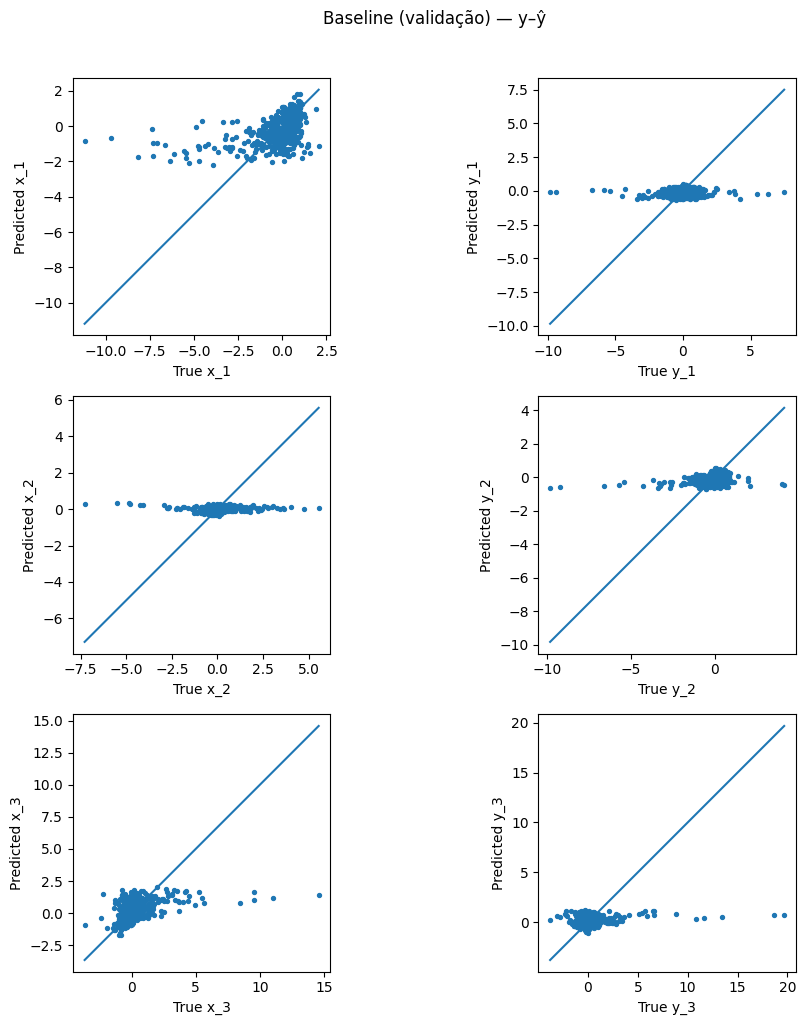

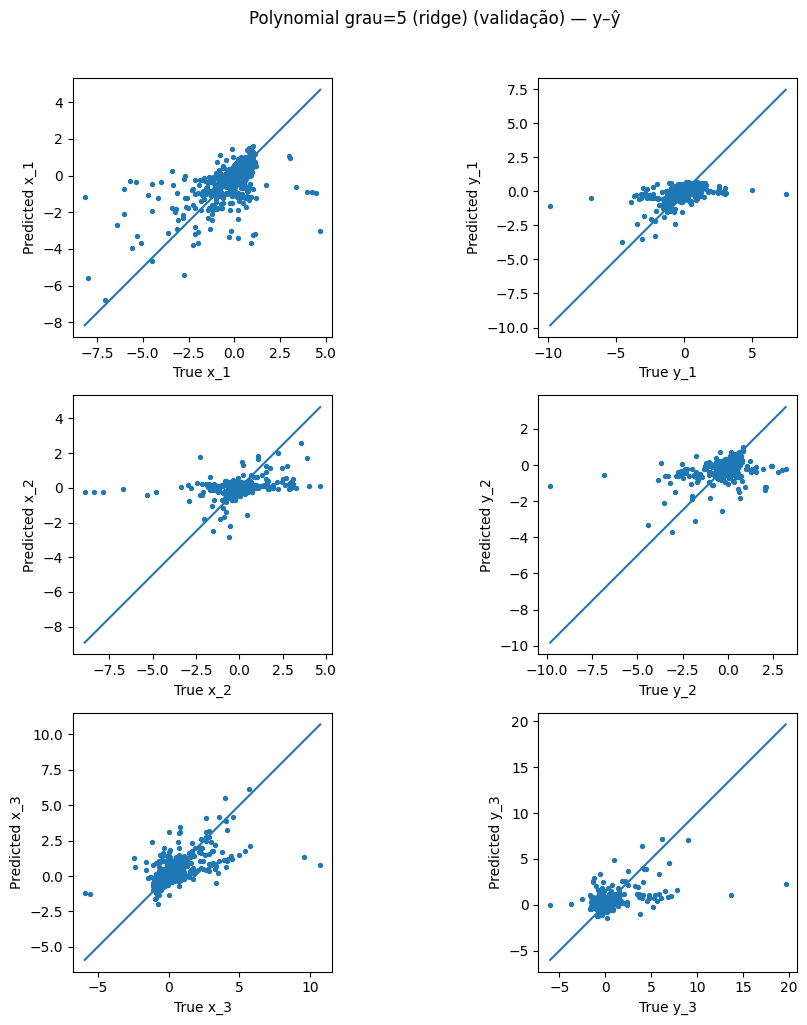

In [14]:
# y–ŷ plots (validação) inline
def plot_y_vs_yhat(y_true, y_pred, title):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    idx = np.random.choice(len(y_true), min(MAX, len(y_true)), replace=False)
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_true[idx,i]); x1 = np.max(y_true[idx,i])
        ax = plt.subplot(3,2,i+1)
        ax.scatter(y_true[idx,i], y_pred[idx,i], s=8)
        ax.plot([x0,x1],[x0,x1])
        ax.set_xlabel('True '+labels[i]); ax.set_ylabel('Predicted '+labels[i])
        ax.set_aspect('equal','box')
    plt.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# baseline
try:
    y_pred_va_baseline = baseline.predict(X_va)
    plot_y_vs_yhat(y_va, y_pred_va_baseline, 'Baseline (validação) — y–ŷ')
except NameError:
    print('Baseline não está disponível nesta sessão.')

# polynomial
y_pred_va_poly = poly_final.predict(X_va)
plot_y_vs_yhat(y_va, y_pred_va_poly, f'Polynomial grau={BEST_DEGREE} ({REGRESSOR}) (validação) — y–ŷ')

In [15]:
# Submissão Kaggle: polynomial_submission.csv
X_submit = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].values
y_submit = poly_final.predict(X_submit)

polynomial_submission = pd.DataFrame({
    'Id': test['Id'],
    'x_1': y_submit[:,0],
    'y_1': y_submit[:,1],
    'x_2': y_submit[:,2],
    'y_2': y_submit[:,3],
    'x_3': y_submit[:,4],
    'y_3': y_submit[:,5],
})
polynomial_submission.to_csv('../outputs/polynomial_submission.csv', index=False)
print('Wrote polynomial_submission.csv')

Wrote polynomial_submission.csv


# ============================================
# 🧩 Task 3.1 — Visualização (pairplot + correlação)
# ============================================

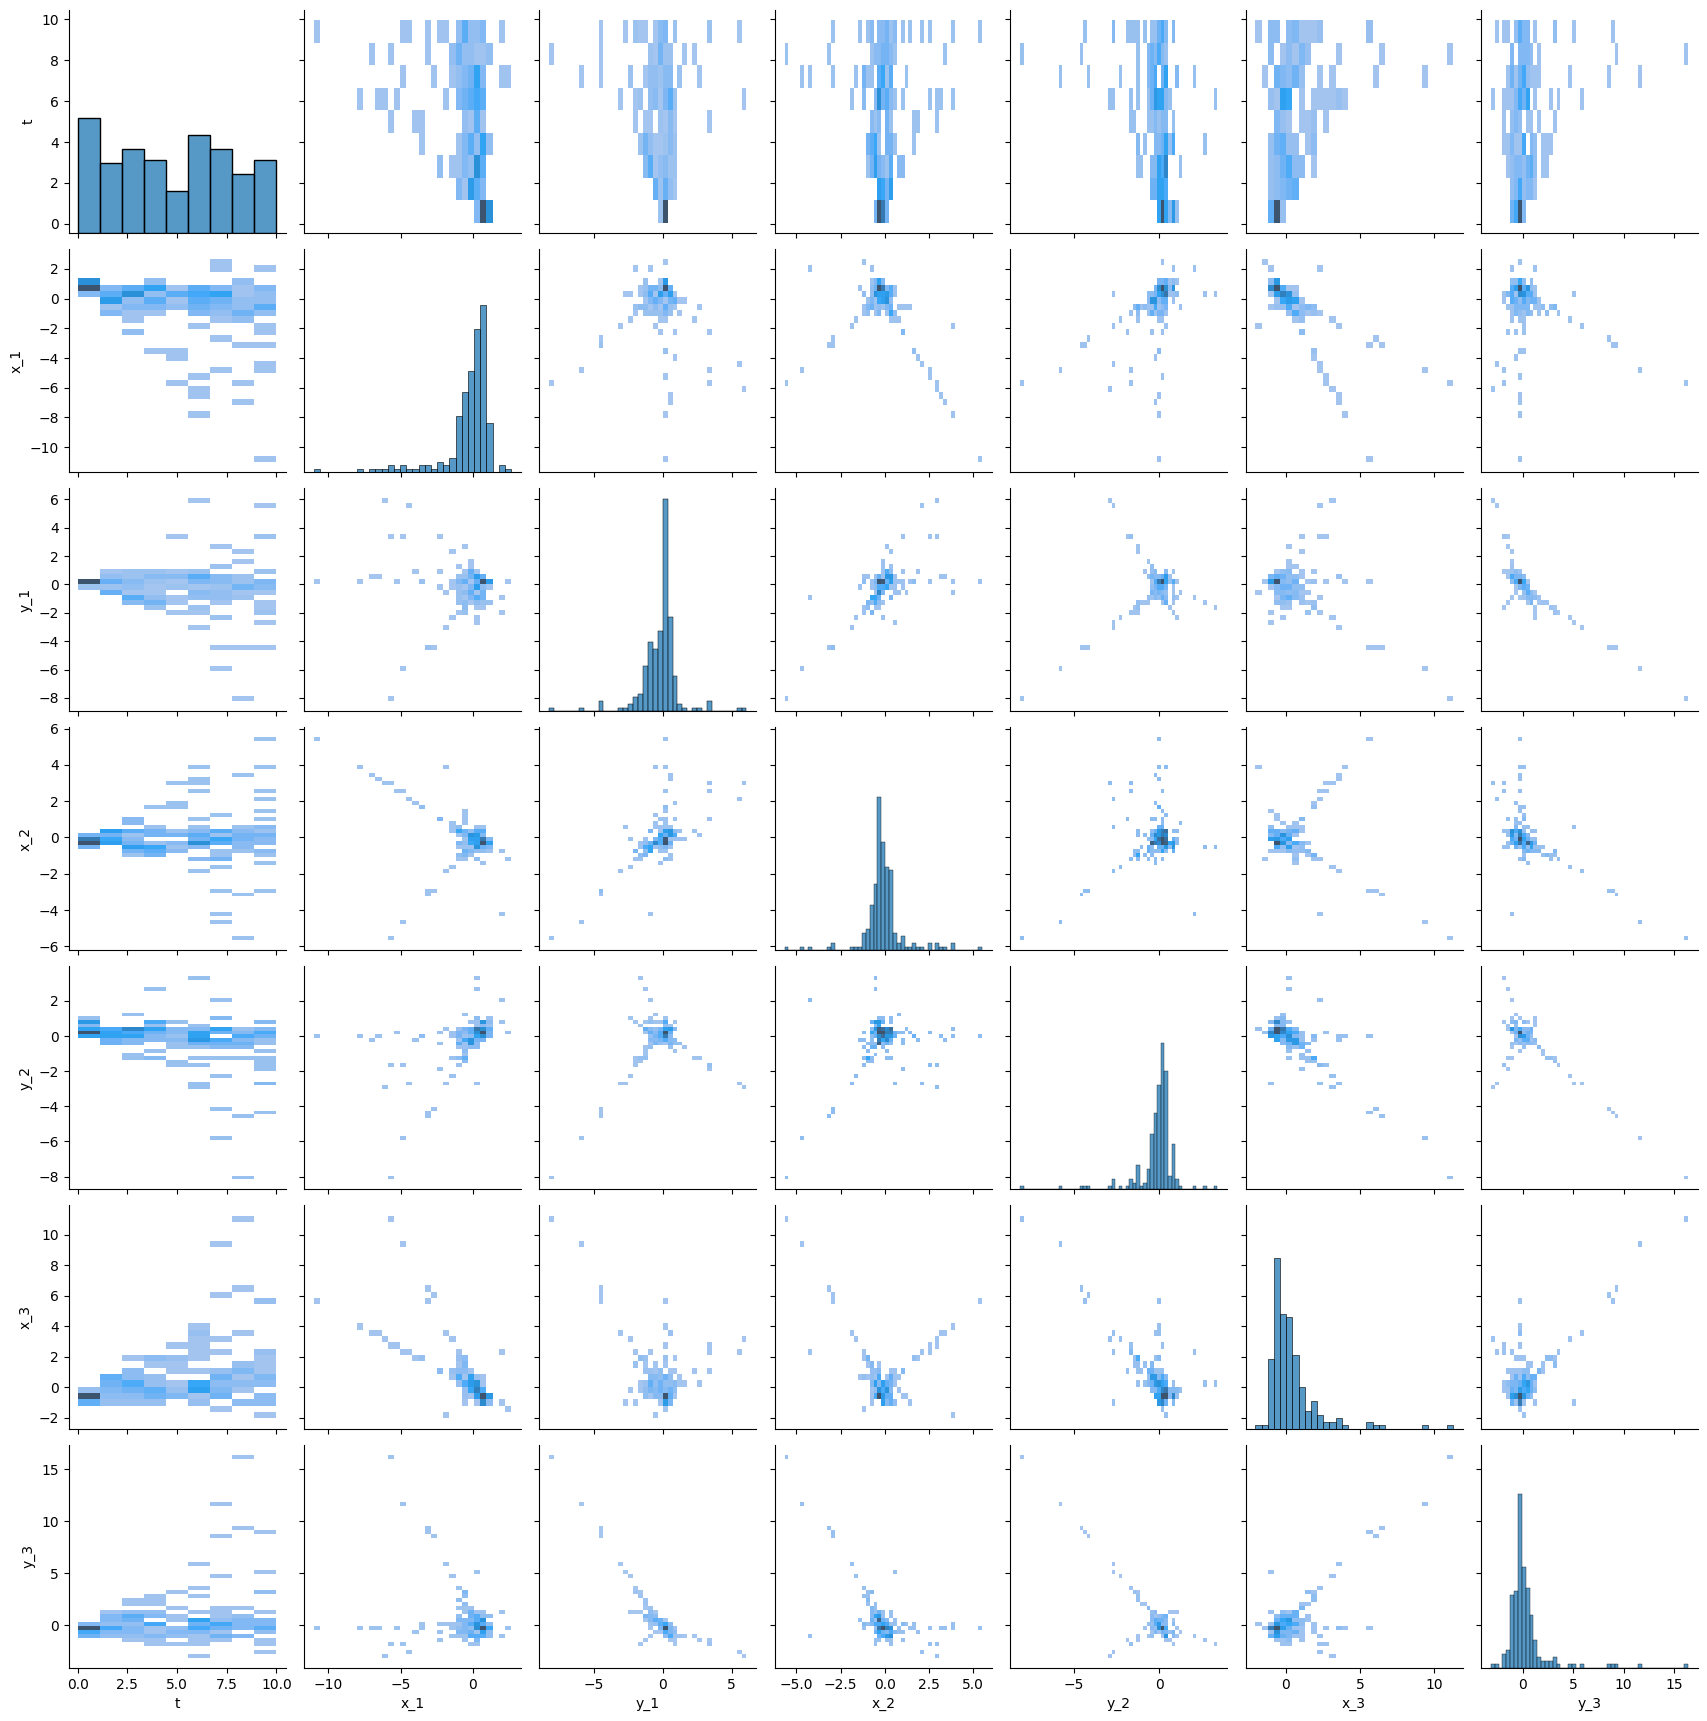

In [ ]:
t_features=feature_cols.index("t")
t = X_va[:, t_features] 

data=np.column_stack((t, y_va)) # Junta o t com o y_va
cols=["t"]+target_cols
df=pd.DataFrame(data, columns=cols) # Faz o dataframe

sns.pairplot(df.sample(200), kind="hist")

<Axes: >

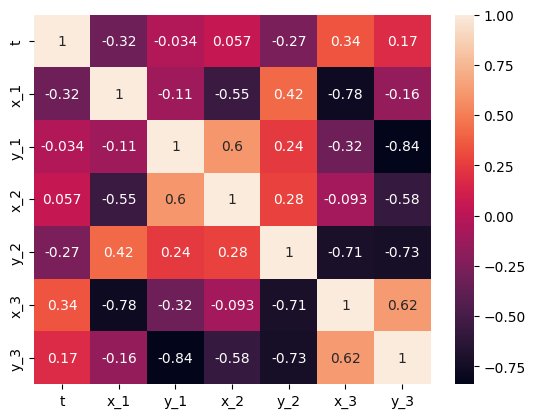

In [17]:
corr = df.corr()
sns.heatmap(corr,annot=True)

# ============================================
# 🧩 Task 3.2 — Variable Reduction (MI Top-K) + modelo reduzido
# ============================================

In [ ]:
SEED = 42
TOPK = 20  
DEG  = int(BEST_DEGREE) if 'BEST_DEGREE' in globals() else 2
REG_KIND = 'ridge' 

def _to_nd(X):
    return X.values if isinstance(X, pd.DataFrame) else X

# Garante idx_keep
if 'idx_keep' not in globals():
    # usa train/val já preparados no notebook
    X_tr_all = _to_nd(df_tr[feature_cols])
    y_tr     = _to_nd(df_tr[target_cols])

    # Mutual Information media (sobre os 6 alvos)
    mi_list = [mutual_info_regression(X_tr_all, y_tr[:, i], random_state=SEED)
               for i in range(y_tr.shape[1])]
    mi_avg = np.mean(np.vstack(mi_list), axis=0)
    idx_keep = np.argsort(mi_avg)[::-1][:TOPK]
    print(f"✅ idx_keep criado (Top-{TOPK}): {[feature_cols[i] for i in idx_keep]}")
else:
    print("ℹ️  idx_keep já existia — a reutilizar.")

# Garante pipe_final 
if 'pipe_final' not in globals():
    X_tr_all = _to_nd(df_tr[feature_cols]);   y_tr = _to_nd(df_tr[target_cols])
    X_va_all = _to_nd(df_va[feature_cols]);   y_va = _to_nd(df_va[target_cols])

    reg = RidgeCV(alphas=np.logspace(-4, 4, 13)) if REG_KIND=='ridge' else LinearRegression()
    pipe_final = Pipeline([
        ('poly',   PolynomialFeatures(degree=DEG, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg',    reg)
    ])
    X_fit = np.vstack([X_tr_all[:, idx_keep], X_va_all[:, idx_keep]])
    y_fit = np.vstack([y_tr, y_va])
    pipe_final.fit(X_fit, y_fit)
    # info opcional
    try:
        yhat_va = pipe_final.predict(X_va_all[:, idx_keep])
        rmse_va = float(np.sqrt(mean_squared_error(y_va, yhat_va)))
        print(f"✅ pipe_final treinado | degree={DEG}, reg={REG_KIND} | RMSE_val≈{rmse_va:.6f}")
    except Exception:
        print("✅ pipe_final treinado.")
else:
    print("ℹ️  pipe_final já existia — a reutilizar.")

# Encontrar df_test
df_test = None
for cand in ['df_test', 'test', 'test_df', 'df_kaggle_test', 'public_test']:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        dfc = globals()[cand]
        if set(feature_cols).issubset(dfc.columns) and len(dfc) >= 1_000_000:
            df_test = dfc
            print(f"✅ Teste da competição encontrado: {cand}  | shape={dfc.shape}")
            break

if df_test is None:
    raise RuntimeError("❌ Não encontrei o DataFrame do test da competição. "
                       "Garante um DF com as colunas de `feature_cols` + `Id`.")

# Prever e montar CSV 
X_kaggle = df_test[feature_cols].to_numpy()
y_pred_kaggle = pipe_final.predict(X_kaggle[:, idx_keep])

# Id automático
id_col = None
for cand in ["Id", "ID", "id"]:
    if cand in df_test.columns:
        id_col = cand; break

if id_col is not None:
    sub = pd.DataFrame({"Id": df_test[id_col]})
else:
    print("⚠️ Nenhuma coluna 'Id' no test — a criar sequencialmente (0..N-1).")
    sub = pd.DataFrame({"Id": np.arange(len(y_pred_kaggle))})

for i, col in enumerate(target_cols):
    sub[col] = y_pred_kaggle[:, i]

#  Guardar documento
out_path = "../outputs/reduced_polynomial_submission.csv"
sub.to_csv(out_path, index=False)
print(f"📄 {out_path} salvo — shape: {sub.shape}")

EXPECTED_ROWS = 1_041_621
if len(sub) != EXPECTED_ROWS:
    print(f"⚠️ Submissão tem {len(sub):,} linhas; esperado {EXPECTED_ROWS:,}. "
          "Confirma que `df_test` é o test da competição e que `feature_cols` bate certo.")
else:
    print("🎯 Contagem de linhas OK para Kaggle.")

✅ idx_keep criado (Top-20): ['y0_3', 'y0_2', 'x0_3', 'x0_2', 't', 'x0_1', 'y0_1']
✅ pipe_final treinado | degree=5, reg=ridge | RMSE_val≈1.254369
✅ Teste da competição encontrado: test  | shape=(1041621, 8)
📄 ../outputs/reduced_polynomial_submission.csv salvo — shape: (1041621, 7)
🎯 Contagem de linhas OK para Kaggle.


# ============================================
# 🧩 Task 3.3 — Variable Augmentation (distâncias / inversos / normas)
# ============================================

Features originais: 7  ->  com augment: 16
✅ RMSE validação (baseline + novas features): 1.369827
📉 RMSE baseline (features originais): 1.254369
ΔRMSE = -0.115458  (Conclusão = melhor com as features originais)


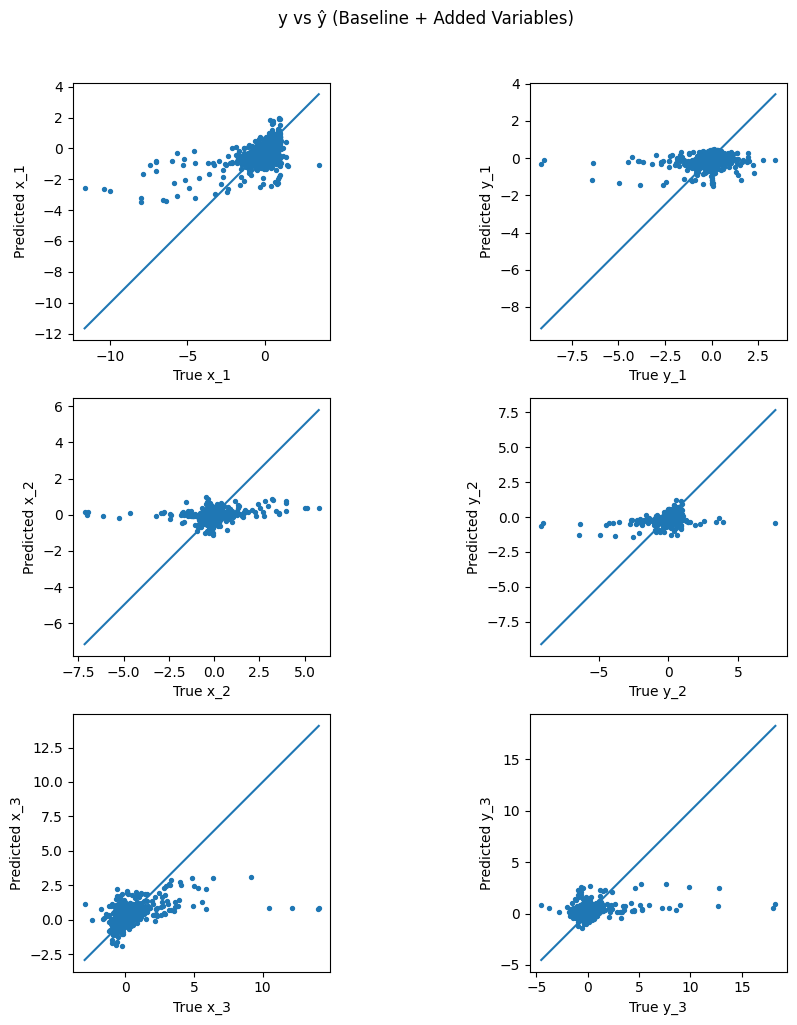

In [ ]:
rng = np.random.default_rng(SEED)

# 1) Função: novas features inspiradas no problema dos 3 corpos
def add_physics_features(df):
    df = df.copy()
    eps = 1e-6

    # distâncias entre corpos
    df["d12"] = np.sqrt((df["x0_1"] - df["x0_2"])**2 + (df["y0_1"] - df["y0_2"])**2)
    df["d13"] = np.sqrt((df["x0_1"] - df["x0_3"])**2 + (df["y0_1"] - df["y0_3"])**2)
    df["d23"] = np.sqrt((df["x0_2"] - df["x0_3"])**2 + (df["y0_2"] - df["y0_3"])**2)

    # inversos das distâncias (aproxima relação gravitacional)
    df["inv_d12"] = 1.0 / (df["d12"] + eps)
    df["inv_d13"] = 1.0 / (df["d13"] + eps)
    df["inv_d23"] = 1.0 / (df["d23"] + eps)

    # normas (distância à origem) de cada corpo
    df["r1"] = np.sqrt(df["x0_1"]**2 + df["y0_1"]**2)
    df["r2"] = np.sqrt(df["x0_2"]**2 + df["y0_2"]**2)
    df["r3"] = np.sqrt(df["x0_3"]**2 + df["y0_3"]**2)

    return df

# 2) Construir datasets com novas features
X_tr_aug = add_physics_features(df_tr[feature_cols])
X_va_aug = add_physics_features(df_va[feature_cols])

print(f"Features originais: {len(feature_cols)}  ->  com augment: {X_tr_aug.shape[1]}")

# 3) Baseline (o MESMO do Task 2): StandardScaler + LinearRegression
baseline_aug = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

baseline_aug.fit(X_tr_aug.values, y_tr)
y_pred_va_aug = baseline_aug.predict(X_va_aug.values)
rmse_aug = np.sqrt(mean_squared_error(y_va, y_pred_va_aug))
print(f"✅ RMSE validação (baseline + novas features): {rmse_aug:.6f}")

# 4) Comparação com o baseline antigo 
try:
    print(f"📉 RMSE baseline (features originais): {rmse_va:.6f}")
    print(f"ΔRMSE = {rmse_va - rmse_aug:.6f}  (Conclusão = melhor com as features originais)")
except NameError:
    # recalcula baseline simples com features originais, só para comparar
    _base = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
    _base.fit(df_tr[feature_cols].values, y_tr)
    _pred = _base.predict(df_va[feature_cols].values)
    _rmse = np.sqrt(mean_squared_error(y_va, _pred))
    print(f"📉 RMSE baseline (recalculado, originais): {_rmse:.6f}")

# 5) y–ŷ plot (um painel por alvo)
try:
    plot_y_vs_yhat(y_va, y_pred_va_aug, "y vs ŷ (Baseline + Added Variables)")
except Exception:
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    idx = rng.choice(len(y_va), min(MAX, len(y_va)), replace=False)
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_va[idx,i]); x1 = np.max(y_va[idx,i])
        ax = plt.subplot(3,2,i+1)
        ax.scatter(y_va[idx,i], y_pred_va_aug[idx,i], s=8, alpha=0.6)
        ax.plot([x0,x1],[x0,x1], lw=1)
        ax.set_xlabel('True '+labels[i]); ax.set_ylabel('Pred '+labels[i])
        ax.set_aspect('equal','box')
    plt.suptitle("y vs ŷ (Baseline + Added Variables)", y=1.02)
    plt.tight_layout(); plt.show()

# ============================================
# 🧩 Task 3.4 — Polynomial + ColumnTransformer (extras com polinómios)
# ============================================

In [ ]:
# builder para augment (usa as features do 3.3)
def _augment_np_builder(feature_cols):
    idx = {n: feature_cols.index(n) for n in ['x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']}
    N_ORIG = len(feature_cols); N_EXTRA = 9

    def augment_np(X):
        X = np.asarray(X, dtype=np.float32)
        eps = 1e-6
        x01, y01 = X[:, idx['x0_1']], X[:, idx['y0_1']]
        x02, y02 = X[:, idx['x0_2']], X[:, idx['y0_2']]
        x03, y03 = X[:, idx['x0_3']], X[:, idx['y0_3']]
        d12 = np.sqrt((x01-x02)**2 + (y01-y02)**2, dtype=np.float32)
        d13 = np.sqrt((x01-x03)**2 + (y01-y03)**2, dtype=np.float32)
        d23 = np.sqrt((x02-x03)**2 + (y02-y03)**2, dtype=np.float32)
        inv_d12 = 1.0/(d12+eps); inv_d13 = 1.0/(d13+eps); inv_d23 = 1.0/(d23+eps)
        r1 = np.sqrt(x01**2 + y01**2, dtype=np.float32)
        r2 = np.sqrt(x02**2 + y02**2, dtype=np.float32)
        r3 = np.sqrt(x03**2 + y03**2, dtype=np.float32)
        extra = np.vstack([d12,d13,d23, inv_d12,inv_d13,inv_d23, r1,r2,r3]).T.astype(np.float32)
        return np.hstack([X.astype(np.float32), extra])

    return augment_np, N_ORIG, N_EXTRA

def validate_poly_regression_3p4(
    X_train, y_train, X_val, y_val,
    degrees=(2,),                 # mantém baixo
    regressor='ridge',
    use_augment=True,
    feature_cols=None,
    interactions_only=True,
    sample_n=None,
    random_state=42,
    plot=True
):
    # regressor 
    reg = (LinearRegression() if regressor in (None, 'linear')
           else RidgeCV(alphas=np.logspace(-4,4,13)) if regressor=='ridge'
           else regressor)

    # normalizar tipos + amostragem segura 
    def _to_nd(X): return X.values if isinstance(X, pd.DataFrame) else X
    Xtr_full = X_train
    ytr_full = y_train.values if isinstance(y_train, pd.DataFrame) else y_train
    Xva_nd   = _to_nd(X_val)
    yva_nd   = y_val.values if isinstance(y_val, pd.DataFrame) else y_val

    rng = np.random.default_rng(random_state)
    if sample_n is not None and len(Xtr_full) > sample_n:
        idx = rng.choice(len(Xtr_full), sample_n, replace=False)
        Xtr_nd = Xtr_full.iloc[idx].values if isinstance(Xtr_full, pd.DataFrame) else Xtr_full[idx]
        ytr_nd = ytr_full[idx]
    else:
        Xtr_nd = _to_nd(Xtr_full)
        ytr_nd = ytr_full

    # preparar augment uma vez (fora do loop)
    if use_augment:
        assert feature_cols is not None, "Passa feature_cols quando use_augment=True."
        augment_np, N_ORIG, N_EXTRA = _augment_np_builder(feature_cols)
        ORIG  = list(range(N_ORIG))
        EXTRA = list(range(N_ORIG, N_ORIG+N_EXTRA))
        sel_orig  = FunctionTransformer(lambda X: X[:, ORIG],  validate=False)
        sel_extra = FunctionTransformer(lambda X: X[:, EXTRA], validate=False)
        to_f32    = FunctionTransformer(lambda X: X.astype(np.float32), validate=False)

    rmse_by_d, feats_by_d = [], []
    best_rmse, best_model = np.inf, None
    results = {}

    for d in degrees:
        if use_augment:
            orig_branch = Pipeline([
                ("sel", sel_orig), ("fp32", to_f32), ("scaler", StandardScaler())
            ])
            extra_branch = Pipeline([
                ("sel", sel_extra), ("fp32", to_f32),
                ("scaler", StandardScaler()),
                ("poly", PolynomialFeatures(degree=d, include_bias=False,
                                            interaction_only=interactions_only))
            ])
            featurizer = FeatureUnion([
                ("orig_scaled", orig_branch),
                ("extra_poly",  extra_branch),
            ])

            pipe = Pipeline([
                ("augment",  FunctionTransformer(augment_np, validate=False)),
                ("features", featurizer),
                ("reg",      reg)
            ])
        else:
            pipe = Pipeline([
                ("poly", PolynomialFeatures(degree=d, include_bias=False)),
                ("scaler", StandardScaler()),
                ("reg", reg)
            ])

        pipe.fit(Xtr_nd, ytr_nd)
        yhat = pipe.predict(Xva_nd)
        rmse = float(np.sqrt(mean_squared_error(yva_nd, yhat)))

        # nº de features polinomiais nas extras (aproximado pela etapa poly do extra_branch)
        try:
            # FeatureUnion guarda uma lista (name, transformer)
            extra_poly = dict(pipe.named_steps['features'].transformer_list)['extra_poly']
            n_out = extra_poly.named_steps['poly'].n_output_features_
        except Exception:
            n_out = getattr(pipe.named_steps.get('poly', None), 'n_output_features_', np.nan)

        results[d] = {'rmse': rmse, 'n_features': n_out}
        rmse_by_d.append(rmse); feats_by_d.append(n_out)
        print(f"grau={d:2d} | n_features={int(n_out) if n_out==n_out else -1:5d} | RMSE_val={rmse:.6f}")

        if rmse < best_rmse:
            best_rmse, best_model = rmse, pipe

    if plot:
        fig, ax1 = plt.subplots(figsize=(7,4))
        ax1.plot(list(degrees), rmse_by_d, marker='o'); ax1.set_xlabel('Grau'); ax1.set_ylabel('RMSE (val)')
        ax2 = ax1.twinx(); ax2.plot(list(degrees), feats_by_d, marker='x'); ax2.set_ylabel('Nº features (extras)')
        ax1.set_title('Task 3.4 — RMSE vs Grau (linha) e Nº de Features (cruzes)')
        plt.tight_layout(); plt.show()

    return best_model, best_rmse, results

grau= 2 | n_features=   45 | RMSE_val=1.313592
[3.4] RMSE validação (augmented, deg=2, ridge): 1.313592


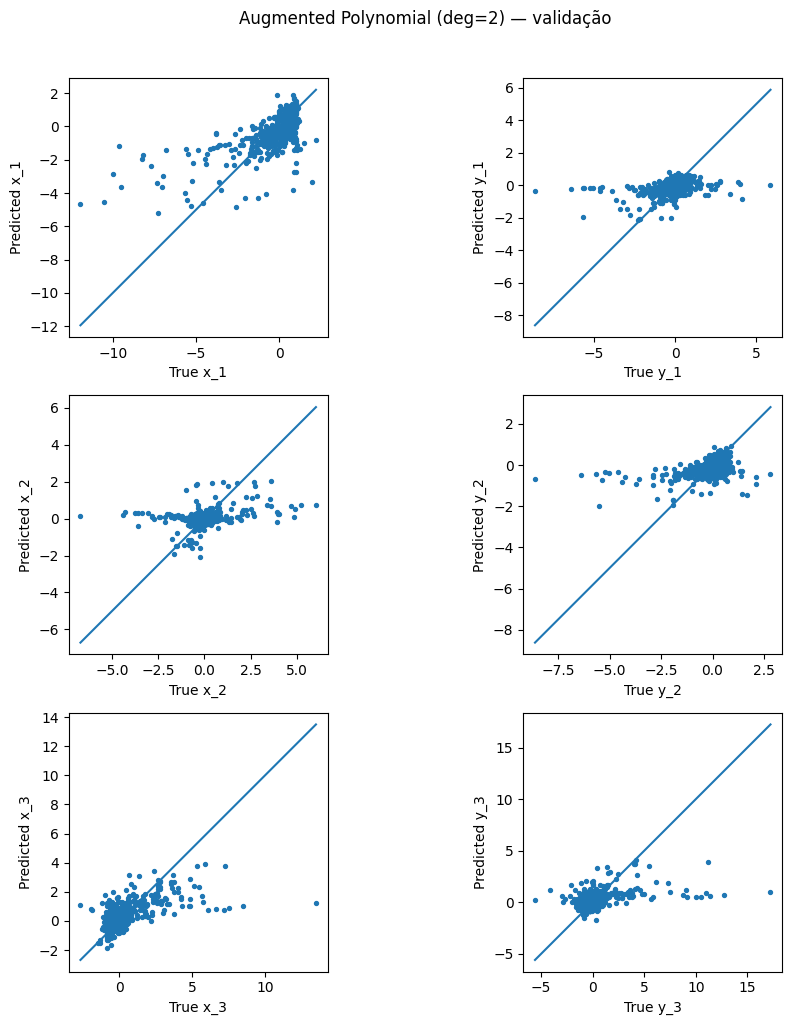

💾 ../outputs/augmented_polynomial_submission.csv salvo — shape: (1041621, 7)


In [36]:
DEGREES   = [2]
REGRESSOR = 'ridge'

Xtr = df_tr[feature_cols]   # DataFrames é mais seguro
Xva = df_va[feature_cols]

model_aug, rmse_aug, info = validate_poly_regression_3p4(
    Xtr, y_tr, Xva, y_va,
    degrees=DEGREES,
    regressor=REGRESSOR,
    use_augment=True,
    feature_cols=feature_cols,
    interactions_only=True,
    sample_n=300_000,   # opcional
    plot=False
)
print(f"[3.4] RMSE validação (augmented, deg={DEGREES[0]}, {REGRESSOR}): {rmse_aug:.6f}")

# y–ŷ
try:
    yhat_va = model_aug.predict(Xva.values)
    plot_y_vs_yhat(y_va, yhat_va, f"Augmented Polynomial (deg={DEGREES[0]}) — validação")
except Exception:
    pass

# 2) Treino final (train+val) e CSV para Kaggle
X_fit = np.vstack([df_tr[feature_cols].to_numpy(), df_va[feature_cols].to_numpy()]).astype(np.float32)
y_fit = np.vstack([y_tr, y_va]).astype(np.float32)

# reconstrói o mesmo pipeline para caber com arrays (ou usa model_aug e dá .fit novamente)
from sklearn.base import clone
pipe_final_aug = clone(model_aug)
pipe_final_aug.fit(X_fit, y_fit)

X_test = test[feature_cols].to_numpy().astype(np.float32)
y_test_pred = pipe_final_aug.predict(X_test).astype(np.float32)

id_col = 'Id' if 'Id' in test.columns else ('ID' if 'ID' in test.columns else 'id')
sub = pd.DataFrame({'Id': test[id_col].to_numpy()})
for i, col in enumerate(target_cols):
    sub[col] = y_test_pred[:, i]

sub.to_csv("../outputs/augmented_polynomial_submission.csv", index=False)
print("💾 ../outputs/augmented_polynomial_submission.csv salvo — shape:", sub.shape)

# ============================================
# 🧩 Task 4.1 — kNN (validação com elbow tolerância)
# ============================================

k= 1 | RMSE=1.056713 | fit=0.72s | pred=0.46s
k= 2 | RMSE=1.048120 | fit=0.71s | pred=0.48s
k= 3 | RMSE=1.049616 | fit=0.71s | pred=0.50s
k= 4 | RMSE=1.053722 | fit=0.70s | pred=0.54s
k= 5 | RMSE=1.060238 | fit=0.70s | pred=0.56s
k= 6 | RMSE=1.058922 | fit=0.70s | pred=0.60s
k= 7 | RMSE=1.049012 | fit=0.71s | pred=0.64s
k= 8 | RMSE=1.028308 | fit=0.69s | pred=0.67s
k= 9 | RMSE=1.022619 | fit=0.71s | pred=0.70s
k=10 | RMSE=1.012405 | fit=0.69s | pred=0.74s
k=11 | RMSE=0.998187 | fit=0.70s | pred=0.76s
k=12 | RMSE=0.987483 | fit=0.69s | pred=0.80s
k=13 | RMSE=0.981760 | fit=0.73s | pred=0.83s
k=14 | RMSE=0.972323 | fit=0.70s | pred=0.86s


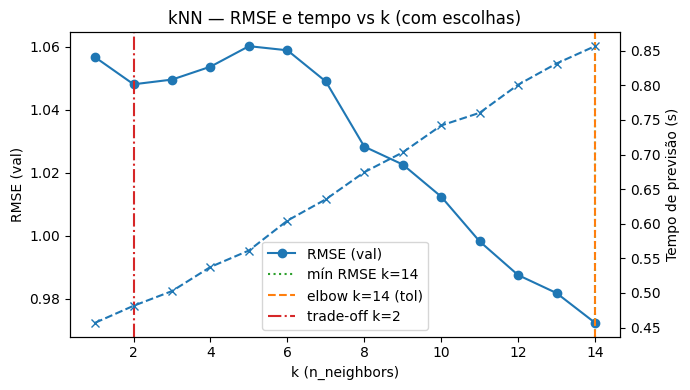

[mín RMSE ] k=14 | RMSE=0.972323
[elbow    ] k=14 | RMSE=0.972323  (método=tol, tol=0.80%)
[trade-off] k= 2 | RMSE=1.048120 (λ=1.0)

[orig] melhor k=14 | RMSE=0.972323
k= 1 | RMSE=1.056713 | fit=0.72s | pred=0.57s
k= 2 | RMSE=1.048140 | fit=0.72s | pred=0.50s
k= 3 | RMSE=1.049617 | fit=0.73s | pred=0.51s
k= 4 | RMSE=1.053748 | fit=0.72s | pred=0.56s
k= 5 | RMSE=1.060238 | fit=0.72s | pred=0.57s
k= 6 | RMSE=1.058917 | fit=0.76s | pred=0.64s
k= 7 | RMSE=1.049013 | fit=0.73s | pred=0.67s
k= 8 | RMSE=1.028310 | fit=0.72s | pred=0.69s
k= 9 | RMSE=1.022628 | fit=0.75s | pred=0.71s
k=10 | RMSE=1.012406 | fit=0.75s | pred=0.80s
k=11 | RMSE=0.998188 | fit=0.75s | pred=0.80s
k=12 | RMSE=0.987488 | fit=0.72s | pred=0.81s
k=13 | RMSE=0.981755 | fit=0.71s | pred=0.86s
k=14 | RMSE=0.972324 | fit=0.73s | pred=0.88s


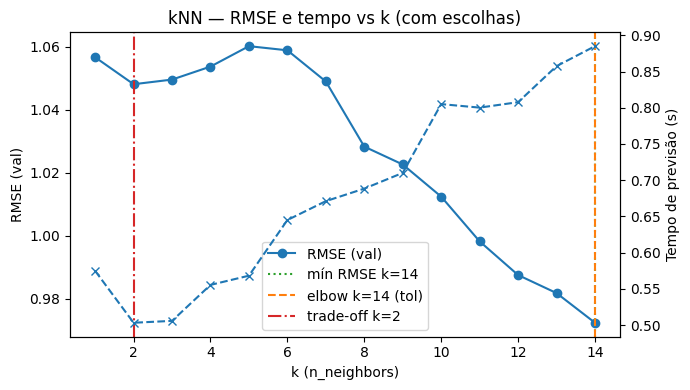

[mín RMSE ] k=14 | RMSE=0.972324
[elbow    ] k=14 | RMSE=0.972324  (método=tol, tol=0.80%)
[trade-off] k= 2 | RMSE=1.048140 (λ=1.0)
[reduced] melhor k=14 | RMSE=0.972324
k= 1 | RMSE=0.988641 | fit=0.14s | pred=62.12s
k= 2 | RMSE=0.988435 | fit=0.14s | pred=58.52s
k= 3 | RMSE=0.987718 | fit=0.13s | pred=60.91s
k= 4 | RMSE=0.980553 | fit=0.14s | pred=64.12s


In [ ]:
def validate_knn_regression(
    X_train, y_train, X_val, y_val, k=range(1,15),
    lam=1.0,                 # peso do tempo no trade-off
    elbow_method="tol",      # 'tol' (recomendado) ou 'geom'
    elbow_tol=0.008          # 0.8% de tolerância ao mínimo
):
    """
    kNN multi-output para vários k. Mostra RMSE/tempo vs k e escolhe:
      - mínimo RMSE
      - elbow (tol: dentro de X% do mínimo | geom: curvatura máxima)
      - trade-off (RMSE + tempo normalizado)
    """
    X_tr = X_train.values if hasattr(X_train, "values") else X_train
    X_va = X_val.values   if hasattr(X_val, "values")   else X_val
    y_tr = y_train.values if hasattr(y_train, "values") else y_train
    y_va = y_val.values   if hasattr(y_val, "values")   else y_val

    base = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(weights="distance"))
    ])

    results, rmse_list, t_fit_list, t_pred_list = [], [], [], []
    for kk in k:
        model = Pipeline(base.steps[:-1] + [
            ("knn", KNeighborsRegressor(n_neighbors=kk, weights="distance"))
        ])
        t0 = time.time(); model.fit(X_tr, y_tr); t_fit = time.time() - t0
        t1 = time.time(); y_pred = model.predict(X_va); t_pred = time.time() - t1
        rmse = float(np.sqrt(mean_squared_error(y_va, y_pred)))
        results.append({"k": kk, "rmse": rmse, "t_fit_s": t_fit, "t_pred_s": t_pred})
        rmse_list.append(rmse); t_fit_list.append(t_fit); t_pred_list.append(t_pred)
        print(f"k={kk:2d} | RMSE={rmse:.6f} | fit={t_fit:.2f}s | pred={t_pred:.2f}s")

    k_grid = np.array(list(k), dtype=float)
    rmses  = np.array(rmse_list, dtype=float)
    times  = np.array(t_pred_list, dtype=float)

    # -------- mínimo RMSE --------
    i_min = np.argmin(rmses)
    k_minrmse, rmse_min = k_grid[i_min], rmses[i_min]

    # -------- elbow --------
    if elbow_method == "tol":
        # menor k dentro de (1+tol) * RMSE_min; se empatar, menor tempo
        mask = rmses <= (1.0 + elbow_tol) * rmse_min
        idxs = np.where(mask)[0]
        if len(idxs) == 0:
            i_elbow = i_min
        else:
            # entre os que satisfazem, escolhe o de menor tempo de previsão
            i_elbow = idxs[np.argmin(times[idxs])]
    else:  # 'geom' = distância à reta dos extremos (pode escolher o pico quando a curva sobe e desce)
        x = (k_grid - k_grid.min()) / (k_grid.max() - k_grid.min() + 1e-12)
        y = (rmses  - rmses.min())  / (rmses.max()  - rmses.min()  + 1e-12)
        p1, p2 = np.array([x[0], y[0]]), np.array([x[-1], y[-1]])
        line_vec = p2 - p1
        distances = np.abs(np.cross(line_vec, np.stack([x, y], axis=1) - p1)) / (np.linalg.norm(line_vec) + 1e-12)
        i_elbow = int(np.argmax(distances))

    k_elbow, rmse_elbow = k_grid[i_elbow], rmses[i_elbow]

    # -------- trade-off (RMSE + tempo) --------
    def _norm(a):
        a = np.asarray(a, float); lo, hi = a.min(), a.max()
        return (a - lo) / (hi - lo + 1e-12)
    score = _norm(rmses) + lam * _norm(times)
    i_score = np.argmin(score)
    k_score, rmse_score = k_grid[i_score], rmses[i_score]

    # -------- gráfico --------
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.plot(k_grid, rmses, marker="o", label="RMSE (val)")
    ax1.set_xlabel("k (n_neighbors)"); ax1.set_ylabel("RMSE (val)")
    ax2 = ax1.twinx(); ax2.plot(k_grid, times, "x--", label="Tempo de previsão (s)")
    ax2.set_ylabel("Tempo de previsão (s)")
    ax1.axvline(k_minrmse, color="tab:green",  linestyle=":",  label=f"mín RMSE k={int(k_minrmse)}")
    ax1.axvline(k_elbow,   color="tab:orange", linestyle="--", label=f"elbow k={int(k_elbow)} ({elbow_method})")
    ax1.axvline(k_score,   color="tab:red",    linestyle="-.", label=f"trade-off k={int(k_score)}")
    ax1.set_title("kNN — RMSE e tempo vs k (com escolhas)")
    ax1.legend(loc="best"); plt.tight_layout(); plt.show()

    print(f"[mín RMSE ] k={int(k_minrmse):2d} | RMSE={rmse_min:.6f}")
    print(f"[elbow    ] k={int(k_elbow):2d} | RMSE={rmse_elbow:.6f}  (método={elbow_method}, tol={elbow_tol:.2%})")
    print(f"[trade-off] k={int(k_score):2d} | RMSE={rmse_score:.6f} (λ={lam})")

    # devolve o modelo no k do elbow (equilíbrio)
    best_model = Pipeline(base.steps[:-1] + [
        ("knn", KNeighborsRegressor(n_neighbors=int(k_elbow), weights="distance"))
    ])
    best_model.fit(X_train if hasattr(X_train, "values") else X_train, y_train if hasattr(y_train, "values") else y_train)
    y_pred_best = best_model.predict(X_val if hasattr(X_val, "values") else X_val)
    return best_model, int(k_elbow), results, y_pred_best
    
# Função auxiliar para criar as novas features (do 3.3)
def make_augment_np(feature_cols):
    idx = {n: feature_cols.index(n) for n in ['x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']}
    def augment_np(X):
        X = np.asarray(X, dtype=np.float32)
        eps = 1e-6
        x01, y01 = X[:, idx['x0_1']], X[:, idx['y0_1']]
        x02, y02 = X[:, idx['x0_2']], X[:, idx['y0_2']]
        x03, y03 = X[:, idx['x0_3']], X[:, idx['y0_3']]
        # distâncias
        d12 = np.sqrt((x01-x02)**2 + (y01-y02)**2)
        d13 = np.sqrt((x01-x03)**2 + (y01-y03)**2)
        d23 = np.sqrt((x02-x03)**2 + (y02-y03)**2)
        # inversos
        inv_d12 = 1.0 / (d12 + eps)
        inv_d13 = 1.0 / (d13 + eps)
        inv_d23 = 1.0 / (d23 + eps)
        # normas
        r1 = np.sqrt(x01**2 + y01**2)
        r2 = np.sqrt(x02**2 + y02**2)
        r3 = np.sqrt(x03**2 + y03**2)
        extra = np.vstack([d12, d13, d23, inv_d12, inv_d13, inv_d23, r1, r2, r3]).T
        return np.hstack([X, extra])
    return augment_np

# ============
# Experimentos
# ============
# 1) Originais
Xtr_orig = df_tr[feature_cols]
Xva_orig = df_va[feature_cols]
knn_orig, k_best_orig, res_orig, yhat_orig = validate_knn_regression(
    Xtr_orig, y_tr, Xva_orig, y_va, k=range(1,15)
)
best_rmse_orig = min(r['rmse'] for r in res_orig)
print(f"\n[orig] melhor k={k_best_orig} | RMSE={best_rmse_orig:.6f}")

# 2) Reduzidas (3.2) — se tiveres idx_keep
have_reduced = 'idx_keep' in globals()
if have_reduced:
    Xtr_red = (df_tr[feature_cols].values)[:, idx_keep]
    Xva_red = (df_va[feature_cols].values)[:, idx_keep]
    knn_red, k_best_red, res_red, yhat_red = validate_knn_regression(
        Xtr_red, y_tr, Xva_red, y_va, k=range(1,15)
    )
    best_rmse_red = min(r['rmse'] for r in res_red)
    print(f"[reduced] melhor k={k_best_red} | RMSE={best_rmse_red:.6f}")
else:
    res_red=[]; best_rmse_red=np.nan; k_best_red=None
    print("[reduced] idx_keep não encontrado — saltei esta variante.")

# 3) Aumentadas (3.3) — cria array com extras e corre
augment = make_augment_np(feature_cols)
Xtr_aug = augment(df_tr[feature_cols].values)
Xva_aug = augment(df_va[feature_cols].values)
knn_aug, k_best_aug, res_aug, yhat_aug = validate_knn_regression(
    Xtr_aug, y_tr, Xva_aug, y_va, k=range(1,15)
)
best_rmse_aug = min(r['rmse'] for r in res_aug)
print(f"[augmented] melhor k={k_best_aug} | RMSE={best_rmse_aug:.6f}")

# =======================
# Gráfico comparativo RMSE
# =======================
plt.figure(figsize=(7,4))
plt.plot([r["k"] for r in res_orig], [r["rmse"] for r in res_orig], "o-", label="Originais")
if have_reduced:
    plt.plot([r["k"] for r in res_red ], [r["rmse"] for r in res_red ], "x--", label="Reduzidas")
plt.plot([r["k"] for r in res_aug ], [r["rmse"] for r in res_aug ], "s-.", label="Aumentadas")
plt.xlabel("k (n_neighbors)"); plt.ylabel("RMSE (val)")
plt.title("kNN — RMSE vs k (orig / reduced / aug)")
plt.legend(); plt.tight_layout(); plt.show()

# ===========
# y–ŷ (visual)
# ===========
try:
    # usa a tua função se existir
    plot_y_vs_yhat(y_va, yhat_aug, f"kNN (Augmented, k={k_best_aug}) — validação")
except Exception:
    # fallback simples
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    idx = np.random.choice(len(y_va), min(500, len(y_va)), replace=False)
    plt.figure(figsize=(10,10))
    for i in range(6):
        ax = plt.subplot(3,2,i+1)
        ax.scatter(y_va[idx,i], yhat_aug[idx,i], s=8)
        lo, hi = y_va[idx,i].min(), y_va[idx,i].max()
        ax.plot([lo,hi],[lo,hi], 'r--', linewidth=1)
        ax.set_xlabel('True '+labels[i]); ax.set_ylabel('Pred '+labels[i]); ax.set_aspect('equal','box')
    plt.suptitle(f"kNN (Augmented, k={k_best_aug}) — validação", y=1.02)
    plt.tight_layout(); plt.show()

# ===========
# Resumo final
# ===========
print("\nResumo (melhor por variante):")
print(f" - Originais : k*={k_best_orig:2d} | RMSE={best_rmse_orig:.6f}")
if have_reduced:
    print(f" - Reduzidas : k*={k_best_red:2d} | RMSE={best_rmse_red:.6f}")
print(f" - Aumentadas: k*={k_best_aug:2d} | RMSE={best_rmse_aug:.6f}")

# ============================================
# 🧩 Task 4.2 — Avaliação final + Submissão Kaggle
# ============================================

In [35]:
best_knn_model = knn_aug
best_k = k_best_aug
print(f"🔹 kNN final: k={best_k}")

# 2️⃣ Avaliar RMSE de validação
y_pred_knn = yhat_aug
rmse_knn = float(np.sqrt(mean_squared_error(y_va, y_pred_knn)))
print(f"✅ RMSE validação (kNN, k={best_k}) = {rmse_knn:.6f}")

# 3️⃣ Comparar com modelos anteriores (se existirem)
rmse_baseline = globals().get("best_rmse_baseline", np.nan)
rmse_poly     = globals().get("best_rmse_poly", np.nan)
rmse_ridge    = globals().get("best_rmse_ridge", np.nan)
rmse_task3    = globals().get("best_rmse_aug", np.nan)

print("\n🔸 Comparação de RMSE (validação):")
print(f" - Baseline Linear : {rmse_baseline:.6f}")
print(f" - Polynomial (3.4) Refaturado: {rmse_task3:.6f}")
print(f" - kNN (4.1)       : {rmse_knn:.6f}")

# 4️⃣ Plot y vs yhat (como no 3.4)
labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
idx = np.random.choice(len(y_va), min(500, len(y_va)), replace=False)
plt.figure(figsize=(10,10))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    ax.scatter(y_va[idx,i], y_pred_knn[idx,i], s=8)
    lo, hi = y_va[idx,i].min(), y_va[idx,i].max()
    ax.plot([lo,hi],[lo,hi],'r--',linewidth=1)
    ax.set_xlabel('True '+labels[i]); ax.set_ylabel('Pred '+labels[i]); ax.set_aspect('equal','box')
plt.suptitle(f"kNN (k={best_k}) — y vs ŷ (validação)", y=1.02)
plt.tight_layout(); plt.show()

# 5️⃣ Geração do ficheiro de submissão Kaggle
# Verifica se o test dataset existe
df_test = None
for cand in ['df_test','test','test_df','df_kaggle_test','public_test']:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        dfc = globals()[cand]
        if set(feature_cols).issubset(dfc.columns) and len(dfc) >= 1_000_000:
            df_test = dfc
            print(f"✅ Teste encontrado: {cand}  | shape={dfc.shape}")
            break
if df_test is None:
    raise RuntimeError("❌ Não encontrei o DataFrame de teste para Kaggle.")

# Previsão
augment = make_augment_np(feature_cols)
X_test_aug = augment(df_test[feature_cols].values)
y_pred_test = best_knn_model.predict(X_test_aug)

# Identificação e construção do DataFrame de submissão
id_col = None
for cand in ["Id","ID","id"]:
    if cand in df_test.columns:
        id_col = cand; break
if id_col is not None:
    sub = pd.DataFrame({"Id": df_test[id_col]})
else:
    print("⚠️ Nenhuma coluna 'Id' — será criada automaticamente (0..N-1)")
    sub = pd.DataFrame({"Id": np.arange(len(y_pred_test))})
for i,col in enumerate(target_cols):
    sub[col] = y_pred_test[:,i]

# Guardar CSV
out_path = "../outputs/knn_submission.csv"
sub.to_csv(out_path, index=False)
print(f"📁 Ficheiro salvo: {out_path}  | shape={sub.shape}")

EXPECTED_ROWS = 1_041_621
if len(sub) != EXPECTED_ROWS:
    print(f"⚠️ Tem {len(sub):,} linhas; esperado {EXPECTED_ROWS:,}")
else:
    print("🎯 Contagem OK — pronto para upload no Kaggle!")

NameError: name 'knn_aug' is not defined